In [1]:
import dv
import cv2
import aedat
import pickle as pkl
import numpy as np
import ffmpeg
from dv import AedatFile

from mlib import *

In [2]:
aedat4_path = r'D:\Dataset\DVS\dv_data\dvSave-2021_10_20_22_45_37.aedat4'
video_path = r'E:\GitHub\DVS-RGB-Recorder\records\video_calib_1.mp4'
video_time_path = op.splitext(video_path)[0]+'_timestamps.txt'


In [3]:
with open(video_time_path, 'r') as f:
    timeseq = f.readlines()
start = int(float(timeseq[0].strip())*1e6)
end = int(float(timeseq[-1].strip())*1e6)
print(start, end, len(timeseq))

1634784362853138 1634784377824653 433


## Using dv

In [4]:
def filter_events(f, start, end, verbose=False):
    events = np.hstack([packet for packet in f['events'].numpy()])
    # print(events.dtype.names)
    # print(events.shape, events[0].shape, events[0])
    mask = np.logical_and(events['timestamp'] > start, events['timestamp'] < end)
    events_selected = events[mask]
    dvs_start = events_selected[0]['timestamp']
    dvs_end = events_selected[-1]['timestamp']
    valid_flag = events[0]['timestamp']<start and events[-1]['timestamp']>end
    if verbose:
        print(f"Event length: {events_selected.shape}")
        print(f"Data validity of this pair: {valid_flag}")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return events_selected

def filter_frames(f, start, end, verbose=False):
    frames = np.hstack([packet for packet in f['frames']])
    frames_selected = np.array(list(filter(lambda x: x.timestamp > start and x.timestamp < end, frames)))
    dvs_start = frames_selected[0].timestamp
    dvs_end = frames_selected[-1].timestamp
    if verbose:
        print(f"Frame length: {frames_selected.shape}")
        print("Frame attributes: [timestamp, image, size]")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return frames_selected

def filter_imus(f, start, end, verbose=False):
    imus = np.hstack([packet for packet in f['imu']])
    imus_selected = np.array(list(filter(lambda x: x.timestamp > start and x.timestamp < end, imus)))
    dvs_start = imus_selected[0].timestamp
    dvs_end = imus_selected[-1].timestamp
    if verbose:
        print(f"IMU length: {imus_selected.shape}")
        print("IMU attributes: [timestamp, gyroscope, accelerometer, temperature]")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return imus_selected

def filter_dvs(f, start, end, verbose=False):
    if verbose:
        print(f.names)
    events_selected = filter_events(f, start, end, verbose=verbose)
    frames_selected = filter_frames(f, start, end, verbose=verbose)
    imus_selected = filter_imus(f, start, end, verbose=verbose)
    return events_selected, frames_selected, imus_selected

def write_dvs(root, events=None, frames=None, imus=None, verbose=False):
    if events is not None:
        event_path = op.join(root, 'events.pkl')
        with open(event_path, 'wb') as f:
            pkl.dump(events, f)
    if frames is not None:
        frame_path = op.join(root, 'frames.pkl')
        with open(frame_path, 'wb') as f:
            pkl.dump(frames, f)
    if imus is not None:
        imu_path = op.join(root, 'imus.pkl')
        with open(imu_path, 'wb') as f:
            pkl.dump(imus, f)
    if verbose:
        print(f"Processed DVS files saved to folder {root}.\n")

def process_dvs_by_rgb(aedat4_path, video_time_path, verbose=False):
    new_root = op.splitext(aedat4_path)[0]
    os.makedirs(new_root,exist_ok=True)
    with open(video_time_path, 'r') as f:
        timeseq = f.readlines()
    start = int(float(timeseq[0].strip())*1e6)
    end = int(float(timeseq[-1].strip())*1e6)
    if verbose:
        print(f"※ Now processing {op.split(aedat4_path)[-1]}...")
        print(f"Start time: {start} μs, End time: {end} μs , Frame Num: {len(timeseq)}")

    with AedatFile(aedat4_path) as f:
        events_selected, frames_selected, imus_selected = filter_dvs(f, start, end, verbose=verbose)
        write_dvs(new_root, events=events_selected, frames=frames_selected, imus=imus_selected, verbose=verbose)

In [120]:
video_time_path = op.splitext(video_path)[0]+'_timestamps.txt'
print(video_time_path)

process_dvs_by_rgb(aedat4_path, video_time_path, verbose=True)

E:\GitHub\DVS-RGB-Recorder\records\video_calib_1_timestamps.txt
※ Now processing dvSave-2021_10_20_22_45_37.aedat4...
Start time: 1634784362853138 μs, End time: 1634784377824653 μs , Frame Num: 433
['events', 'frames', 'imu']
Event length: (4336870,)
Data validity of this pair: True
DVS start: 1634784362853142 μs, RGB start: 1634784362853138 μs, Delta: 4 μs
DVS end: 1634784377824652 μs, RGB end: 1634784377824653 μs, Delta: 1 μs
Frame length: (454,)
Frame attributes: [timestamp, image, size]
DVS start: 1634784362861658 μs, RGB start: 1634784362853138 μs, Delta: 8520 μs
DVS end: 1634784377810658 μs, RGB end: 1634784377824653 μs, Delta: 13995 μs
IMU length: (12167,)
IMU attributes: [timestamp, gyroscope, accelerometer, temperature]
DVS start: 1634784362853177 μs, RGB start: 1634784362853138 μs, Delta: 39 μs
DVS end: 1634784377824239 μs, RGB end: 1634784377824653 μs, Delta: 414 μs
Processed DVS files saved to folder D:\Dataset\DVS\dv_data\dvSave-2021_10_20_22_45_37.


In [112]:
new_root = op.splitext(aedat4_path)[0]
os.makedirs(new_root,exist_ok=True)
print(new_root)

D:\Dataset\DVS\dv_data\dvSave-2021_10_20_18_08_03


In [113]:
f = AedatFile(aedat4_path)
new_root = op.splitext(aedat4_path)[0]
os.makedirs(new_root,exist_ok=True)

events_selected, frames_selected, imus_selected = filter_dvs(f, start, end, verbose=True)
write_dvs(new_root, events=events_selected, frames=frames_selected, imus=imus_selected)

['events', 'frames', 'imu']
Event length: (379681,)
Data validity of this pair: True
DVS start: 1634767701795530 μs, RGB start: 1634767701795091 μs, Delta: 439 μs
DVS end: 1634767710561046 μs, RGB end: 1634767710561092 μs, Delta: 46 μs
Frame length: (265,)
Frame attributes: [timestamp, image, size]
DVS start: 1634767701821658 μs, RGB start: 1634767701795091 μs, Delta: 26567 μs
DVS end: 1634767710533658 μs, RGB end: 1634767710561092 μs, Delta: 27434 μs
IMU length: (7123,)
IMU attributes: [timestamp, gyroscope, accelerometer, temperature]
DVS start: 1634767701796087 μs, RGB start: 1634767701795091 μs, Delta: 996 μs
DVS end: 1634767710560302 μs, RGB end: 1634767710561092 μs, Delta: 790 μs


In [27]:
events = np.hstack([packet for packet in f['events'].numpy()])
print(events.dtype.names)
print(events.shape, events[1110])

# Access information of all events by type
timestamps, x, y, polarities = events['timestamp'], events['x'], events['y'], events['polarity']

('timestamp', 'x', 'y', 'polarity', '_p1', '_p2')
(6748109,) (1634767700261673, 116, 45, 1, 0, 0)


In [107]:
frame = frames[110]
print(frame.position, frame.timestamp, frame.size, frame.timestamp_end_of_exposure, frame.timestamp_end_of_frame, frame.timestamp_start_of_exposure, frame.timestamp_start_of_frame)
frame.image

(0, 0) 1634767703834658 (320, 240) 0 0 0 0


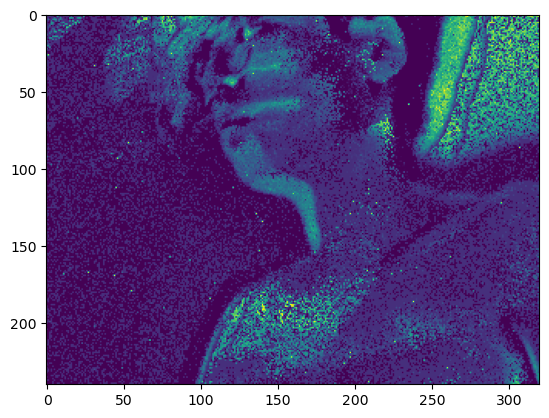

In [41]:
mcv.imshow(frame.image)
plt.show()

In [125]:
from datetime import datetime

now = datetime.now() # current date and time
date_time = now.strftime("%Y_%m_%d_%H_%M_%S")
print(date_time)

2021_10_20_22_54_22


In [13]:
out_filename='movie_1.mp4'

In [18]:
# ffmpeg.input(video_path).trim(start_frame=10, end_frame=30).output(out_filename).run()
ffmpeg.input(video_path).trim(start=2, end=6).output(out_filename).overwrite_output().run()


(None, None)

## Call Potplayer

In [22]:
import potplayer
potplayer.run(r'D:\MMD\Projects\exp-01-miku-street\video.avi') 

## VMD to JSON

In [19]:
import json
import xmltodict

In [64]:
input_files = [
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包3\magunet(Ver2)\蝶モーション.vmd',
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包3\JoJo - Crazy Noisy Bizarre Town [BigYellowAlien]\Crazy Noisy Bizarre Town - Motion [BigYellowAlien].vmd',
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包1\BlueStarモーション',
    ]


In [23]:
from vmd import get_bone_only

In [66]:
bone_state, bone_state_calculator, vam_body, motion_data = get_bone_only(input_files[-2])

Loading motion file...
Calculating motion for: hip
Calculating motion for: abdomen2
Calculating motion for: neck
Calculating motion for: head
Calculating motion for: pelvis
Calculating motion for: lThigh
Calculating motion for: rThigh
Calculating motion for: rKnee
Calculating motion for: lKnee
Calculating motion for: rShoulder
Calculating motion for: lShoulder
Calculating motion for: lArm
Calculating motion for: rArm
Calculating motion for: lElbow
Calculating motion for: rElbow
Calculating motion for: rHand
Calculating motion for: lHand
Calculating motion for: lFoot
Calculating motion for: rFoot


In [56]:
print(bone_state.keys())
print(len(bone_state['hip'].keys()))

dict_keys(['hip', 'abdomen2', 'neck', 'head', 'pelvis', 'lThigh', 'rThigh', 'rKnee', 'lKnee', 'rShoulder', 'lShoulder', 'lArm', 'rArm', 'lElbow', 'rElbow', 'rHand', 'lHand', 'lFoot', 'rFoot'])
2201


In [62]:
[x for x in bone_state['rShoulder'].keys() if x not in range(2200)]

[]

In [63]:
bone_state['hip']

{0: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': False,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 1: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 2: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 3: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 4: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 5: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 6: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 7: {'pos': {'x': 0.0, 'y': -0.04999999701976776, 'z': 0.0},
  'rot_on': True,
  'rot': Quaternion(1.0, 0.0, 0.0, 0.0)},
 8: {'pos': {'x': 0.0, 'y': -0.